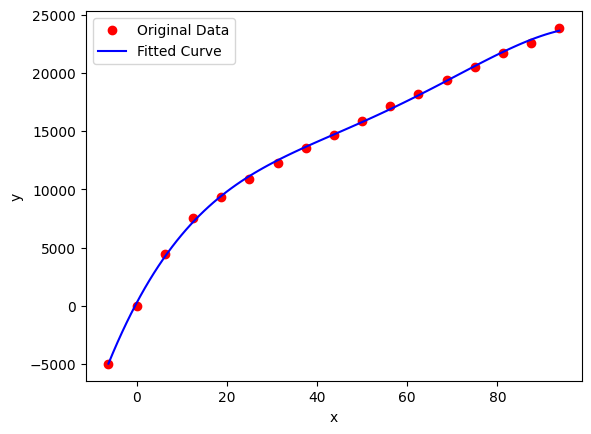

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

imu_data = np.loadtxt("/home/nuci7/project/cf2/crazyflie-firmware/control/data/imu_data_0103-1417.csv", delimiter=',')

# acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, motor1, motor2, motor3, motor4, current_time, height
# Normalizing the PWM
imu_data[:,6:10] = imu_data[:,6:10]/((1<<16)-1)


import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 原始数据
x = np.linspace(0-6.25,93.75,int(93.75/6.25)+2)
y = np.array([-5000, 0, 4485, 7570, 9374, 10885, 12277, 13522, 14691, 15924, 17174, 18179, 19397, 20539, 21692, 22598, 23882])

# 定义多项式函数
def func(x, a, b, c, d, e):
    return e * x**4 + d * x**3 + a * x**2 + b * x + c

# 进行曲线拟合
params, params_covariance = curve_fit(func, x, y)

# 提取拟合参数
a = params[0]
b = params[1]
c = params[2]
d = params[3]
e = params[4]

# 生成拟合曲线的x值
x_fit = np.linspace(x.min(), x.max(), 100)

# 计算拟合曲线的y值
y_fit = func(x_fit, a, b, c, d, e)

# 绘制原始数据和拟合曲线
plt.plot(x, y, 'ro', label='Original Data')
plt.plot(x_fit, y_fit, 'b-', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**Get moter speed RPM**

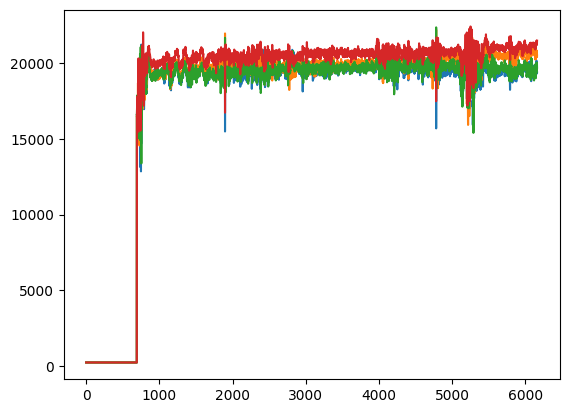

In [2]:
# def thrust2RPM(m1,m2,):
RPM = func(np.asarray(imu_data[:,6:10]*100), a, b, c, d, e)

plt.plot(RPM)

**Get rotation matrix R**

In [3]:
# Convert quaternion to rotation matrix
def rotation_matrix(quat):
    rot_mat = np.ones([3,3])
    a = quat[0]**2
    b = quat[1]**2
    c = quat[2]**2
    d = quat[3]**2
    e = quat[0]*quat[1]
    f = quat[0]*quat[2]
    g = quat[0]*quat[3]
    h = quat[1]*quat[2]
    i = quat[1]*quat[3]
    j = quat[2]*quat[3]
    rot_mat[0,0] = a - b - c + d
    rot_mat[0,1] = 2 * (e - j)
    rot_mat[0,2] = 2 * (f + i)
    rot_mat[1,0] = 2 * (e + j)
    rot_mat[1,1] = -a + b - c + d
    rot_mat[1,2] = 2 * (h - g)
    rot_mat[2,0] = 2 * (f - i)
    rot_mat[2,1] = 2 * (h + g)
    rot_mat[2,2] = -a - b + c + d
    
    return rot_mat

In [88]:
import math

def quatdecompress(comp):
    # 从解压缩整数中提取索引和符号位
    i_largest = comp >> 30
    negate = (comp >> 29) & 1

    # 解压缩四元数的分量
    quat = [0.0, 0.0, 0.0, 0.0]
    for i in range(4):
        if i != i_largest:
            # 从整数中提取符号位和幅度
            negbit = (comp >> 28) & 1
            mag = comp & ((1 << 9) - 1)

            # 计算原始值
            value = (mag / ((1 << 9) - 1)) * math.sqrt(2.0)
            if negbit != negate:
                value = -value

            # 存储解压缩后的分量
            quat[i] = value

            # 移动到下一个四元数分量
            comp >>= 10

    # 根据最大元素的正负号确定四元数的w分量
    w = math.sqrt(1.0 - sum(q * q for q in quat))
    quat[i_largest] = w if negate == 0 else -w

    return quat

# 示例使用
compressed_quat = 3054198967
uncompressed_quat = quatdecompress(compressed_quat)
print(uncompressed_quat)

ValueError: math domain error

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

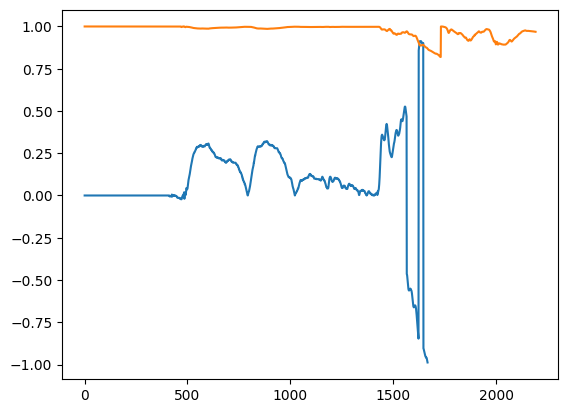

In [85]:
hhh = []
for i in range(1668):
    print(i)    
    quat = int(imu_data[i,4])
    compressed_quat = quat # Replace with your compressed quaternion value
    uncompressed_quat = quatdecompress(compressed_quat)
    hhh.append(uncompressed_quat[0])
plt.plot(hhh)
plt.plot(imu_data[:,3])
print(uncompressed_quat)  # Output the uncompressed quaternion
print(imu_data[240,:4])

In [4]:
# 创建旋转矩阵
def rpy2Rotation(roll, pitch, yaw):
    rotation_matrix = np.array([
        [np.cos(yaw)*np.cos(pitch), -np.sin(yaw)*np.cos(roll) + np.cos(yaw)*np.sin(pitch)*np.sin(roll), np.sin(yaw)*np.sin(roll) + np.cos(yaw)*np.sin(pitch)*np.cos(roll)],
        [np.sin(yaw)*np.cos(pitch), np.cos(yaw)*np.cos(roll) + np.sin(yaw)*np.sin(pitch)*np.sin(roll), -np.cos(yaw)*np.sin(roll) + np.sin(yaw)*np.sin(pitch)*np.cos(roll)],
        [-np.sin(pitch), np.cos(pitch)*np.sin(roll), np.cos(pitch)*np.cos(roll)]
    ])
    return rotation_matrix


In [5]:
R = np.zeros([imu_data.shape[0], 3, 3])
for i in range(imu_data.shape[0]):
    R[i, :, :] = rotation_matrix([0,0,0,1])

**Fixed CT to get Fa**

In [23]:
m = 0.033 # mass
g = 9.81 # gravity
rho = 1.225 # air density
D = 0.05  # diameter of the rotor
rpm2rs = 60 ** 2

C_t_fixed = 0.09937873049125099
Fa = np.zeros([imu_data.shape[0], 3])
F = R[:, :, 2]

In [24]:
# A_d: acceleration rate


for i in range(imu_data.shape[0]):
    F_whole = m * imu_data[i, 0:3]/1000  # G = mg
    # temp[2] += m * g
    r_square = RPM[i, 0]**2 + RPM[i, 1]**2 + RPM[i, 2]**2 + RPM[i, 3]**2
    thrust = C_t_fixed / rpm2rs * rho * D ** 4 * r_square # c_t = C_t_fixed / rpm2rs * rho * D ** 4. r_square = n**2+n**2+n**2+n**2
    Fa[i, :] = F_whole - thrust * F[i, :]

**Take a look at Fa**

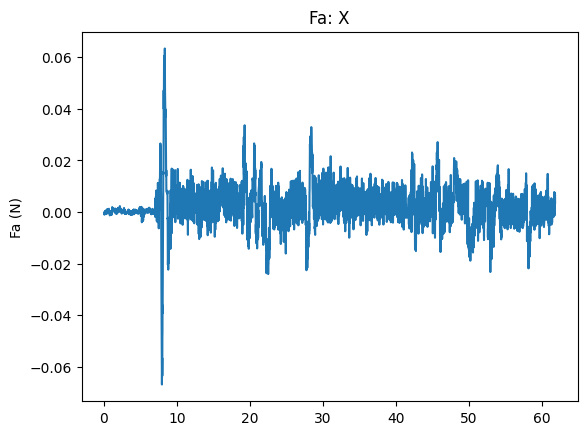

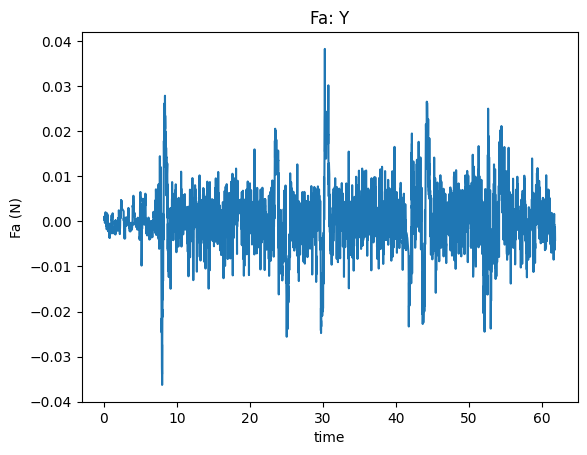

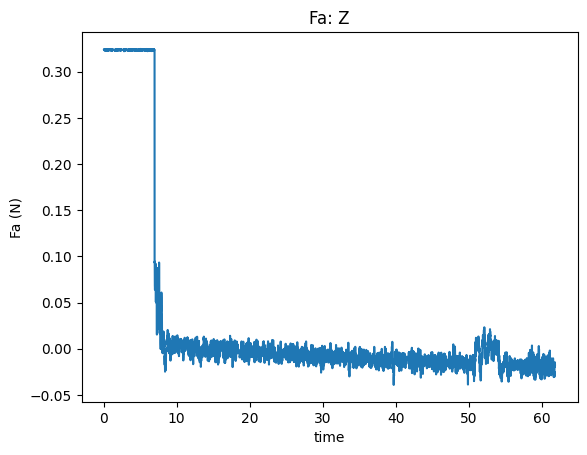

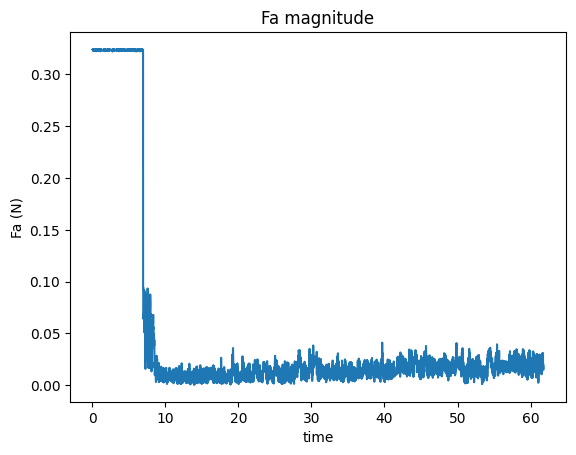

In [36]:
line1, = plt.plot(imu_data[:,-2], Fa[:, 0])
plt.title("Fa: X")
plt.ylabel("Fa (N)")
plt.show()

line1, = plt.plot(imu_data[:,-2], Fa[:, 1])
plt.title("Fa: Y")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

plt.figure()
# line1, = plt.plot(imu_data[1500:,-2], Fa[1500:, 2])
# line1, = plt.plot(imu_data[1500:,-2], imu_data[1500:,-1]/10000)
line1, = plt.plot(imu_data[:,-2], Fa[:,2])
# line1, = plt.plot(imu_data[:,-2], imu_data[:,-1]/10000)
plt.title("Fa: Z")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

Fa_norm = np.zeros(imu_data[:,-2].shape[0])
for i in range(imu_data[:,-2].shape[0]):
    Fa_norm[i] = np.linalg.norm(Fa[i, :])
line1, = plt.plot(imu_data[:,-2], Fa_norm)
plt.title("Fa magnitude")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()